In [ ]:
import pandas as pd

# Cargar el archivo JSON ya mapeado (fichas_tecnicas_mapped_atc.json)
medicamentos_df = pd.read_json("../../data/outputs/fichas_tecnicas_mapped_atc.json")

# Mostrar las primeras filas para verificar la carga
display(medicamentos_df.head())

,nombre,indicaciones_terapeuticas,posologia,contraindicaciones,advertencias_precauciones,interacciones,fertilidad_embarazo_lactancia,efectos_capacidad_conducir,reacciones_adversas,codigo_atc,fecha_revision,excipientes,incompatibilidades,grupo_anatomico,subgrupo_terapeutico,subgrupo_farmacologico
0,A.A.S._100_mg_COMPRIMIDOS,No especificado, Como inhibidor de la agregación plaquetaria ...,No especificado,No especificado,No especificado,No especificado,No especificado,No especificado,D01AE09,No especificado,No especificado,No especificado,Dermatológicos,Agentes antifúngicos para uso dermatológico,Agentes antifúngicos tópicos


In [ ]:
# Verificar la estructura de los datos y columnas
display(medicamentos_df.info())

# Verificar la cantidad de valores faltantes en cada columna
display(medicamentos_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   nombre                         1 non-null      object
 1   indicaciones_terapeuticas      1 non-null      object
 2   posologia                      1 non-null      object
 3   contraindicaciones             1 non-null      object
 4   advertencias_precauciones      1 non-null      object
 5   interacciones                  1 non-null      object
 6   fertilidad_embarazo_lactancia  1 non-null      object
 7   efectos_capacidad_conducir     1 non-null      object
 8   reacciones_adversas            1 non-null      object
 9   codigo_atc                     1 non-null      object
 10  fecha_revision                 1 non-null      object
 11  excipientes                    1 non-null      object
 12  incompatibilidades             1 non-null      object
 13  grupo_ana

None

nombre                           0
indicaciones_terapeuticas        0
posologia                        0
contraindicaciones               0
advertencias_precauciones        0
interacciones                    0
fertilidad_embarazo_lactancia    0
efectos_capacidad_conducir       0
reacciones_adversas              0
codigo_atc                       0
fecha_revision                   0
excipientes                      0
incompatibilidades               0
grupo_anatomico                  0
subgrupo_terapeutico             0
subgrupo_farmacologico           0
dtype: int64

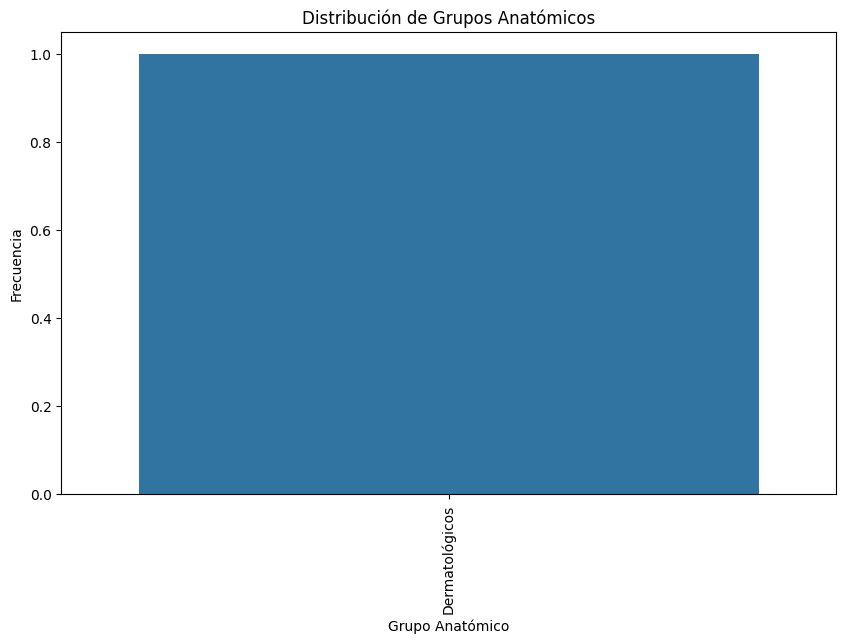

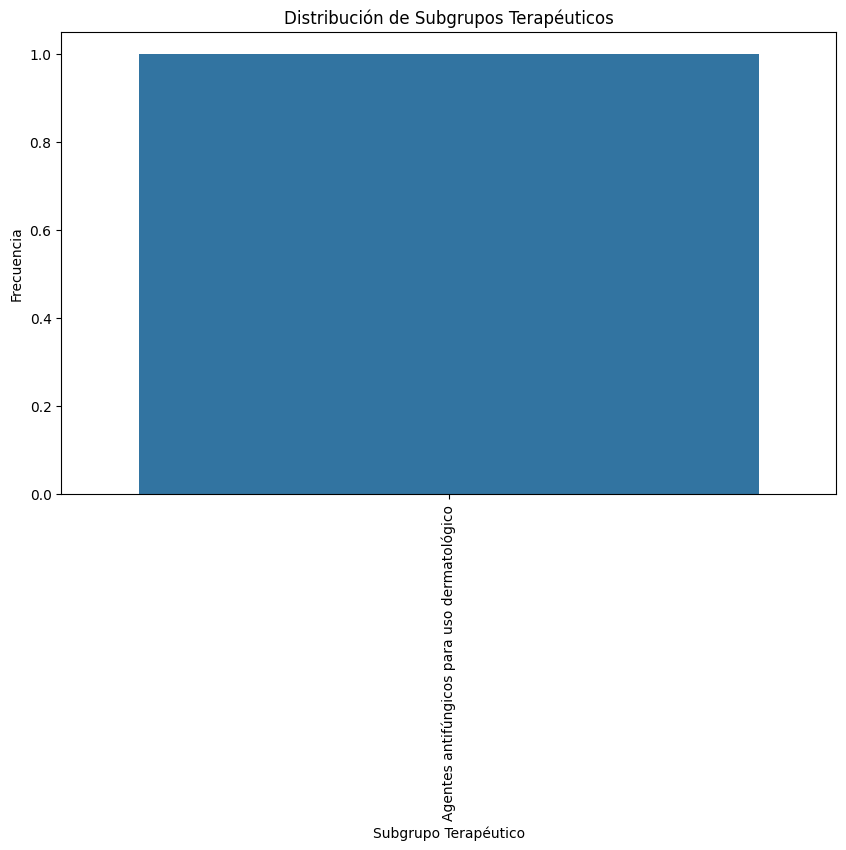

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribución de Grupos Anatómicos
plt.figure(figsize=(10, 6))
sns.countplot(
    data=medicamentos_df,
    x="grupo_anatomico",
    order=medicamentos_df["grupo_anatomico"].value_counts().index,
)
plt.xticks(rotation=90)
plt.title("Distribución de Grupos Anatómicos")
plt.xlabel("Grupo Anatómico")
plt.ylabel("Frecuencia")
plt.show()

# Distribución de Subgrupos Terapéuticos
plt.figure(figsize=(10, 6))
sns.countplot(
    data=medicamentos_df,
    x="subgrupo_terapeutico",
    order=medicamentos_df["subgrupo_terapeutico"].value_counts().index,
)
plt.xticks(rotation=90)
plt.title("Distribución de Subgrupos Terapéuticos")
plt.xlabel("Subgrupo Terapéutico")
plt.ylabel("Frecuencia")
plt.show()

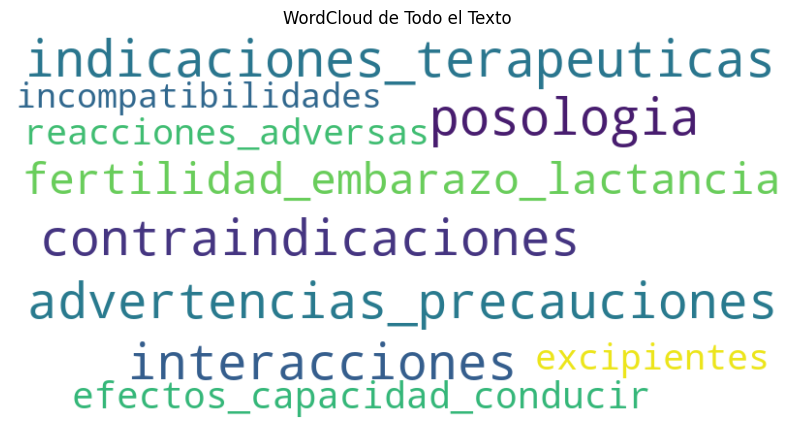

In [ ]:
from wordcloud import WordCloud

# Unir todos los textos de todas las columnas en un solo string
texto_completo = " ".join(
    medicamentos_df[
        [
            "indicaciones_terapeuticas",
            "posologia",
            "contraindicaciones",
            "advertencias_precauciones",
            "interacciones",
            "fertilidad_embarazo_lactancia",
            "efectos_capacidad_conducir",
            "reacciones_adversas",
            "excipientes",
            "incompatibilidades",
        ]
    ].fillna("")
)

# Generar la WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    texto_completo
)

# Mostrar la WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud de Todo el Texto")
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Unir todos los textos de todas las columnas en un solo string
texto_completo = " ".join(
    medicamentos_df[
        [
            "indicaciones_terapeuticas",
            "posologia",
            "contraindicaciones",
            "advertencias_precauciones",
            "interacciones",
            "fertilidad_embarazo_lactancia",
            "efectos_capacidad_conducir",
            "reacciones_adversas",
            "excipientes",
            "incompatibilidades",
        ]
    ].fillna("")
)

# Cargar las stopwords desde el archivo
with open("../../assets/spanish_stopwords.txt", "r", encoding="utf-8") as f:
    stopwords = f.read().splitlines()

# Crear el vectorizador TF-IDF utilizando las stopwords en español
tfidf = TfidfVectorizer(stop_words=stopwords)

# Ajustar el modelo TF-IDF al texto concatenado
tfidf_matrix = tfidf.fit_transform([texto_completo])

# Convertir la matriz TF-IDF a un DataFrame para facilitar la visualización
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Mostrar las 10 palabras con mayor TF-IDF (sumando por columna)
top_n = 10
top_n_words = tfidf_df.sum().sort_values(ascending=False).head(top_n)
print("Top 10 palabras por TF-IDF:\n", top_n_words)

Top 10 palabras por TF-IDF:
 advertencias_precauciones        0.316228
contraindicaciones               0.316228
efectos_capacidad_conducir       0.316228
excipientes                      0.316228
fertilidad_embarazo_lactancia    0.316228
incompatibilidades               0.316228
indicaciones_terapeuticas        0.316228
interacciones                    0.316228
posologia                        0.316228
reacciones_adversas              0.316228
dtype: float64


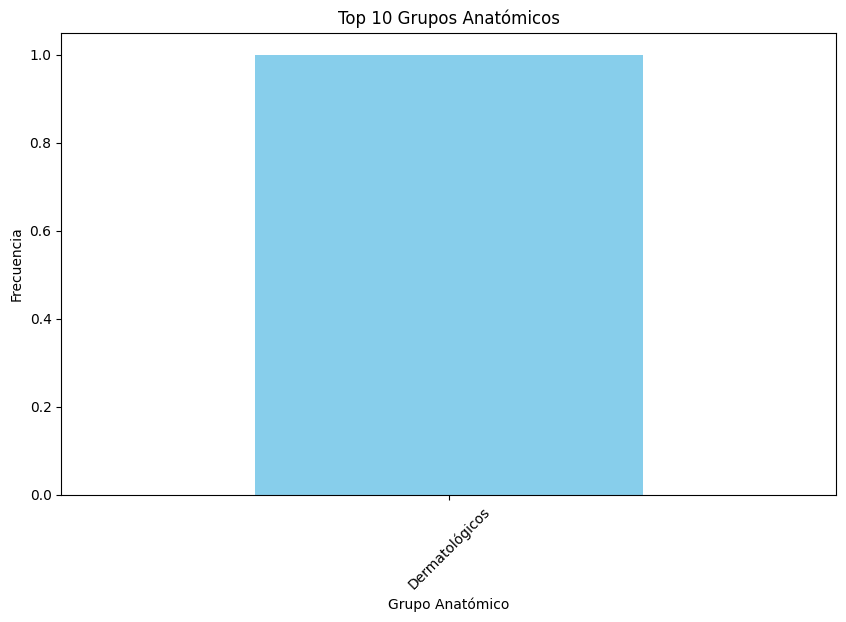

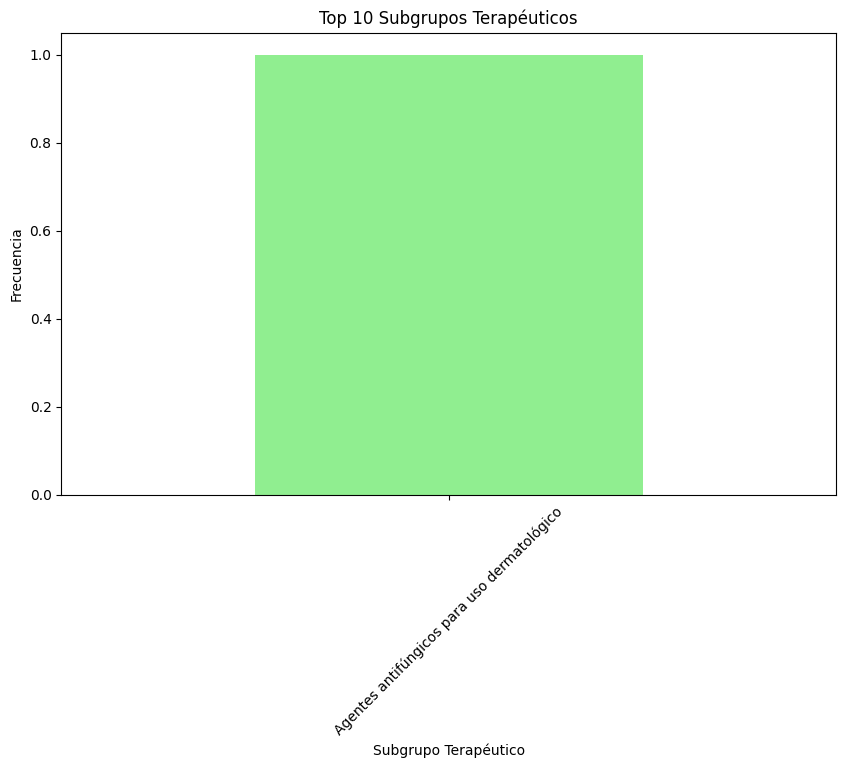

In [ ]:
# Top 10 Grupos Anatómicos
grupo_anatomico_top = medicamentos_df["grupo_anatomico"].value_counts().head(10)

plt.figure(figsize=(10, 6))
grupo_anatomico_top.plot(kind="bar", color="skyblue")
plt.title("Top 10 Grupos Anatómicos")
plt.xlabel("Grupo Anatómico")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.show()

# Top 10 Subgrupos Terapéuticos
subgrupo_terapeutico_top = (
    medicamentos_df["subgrupo_terapeutico"].value_counts().head(10)
)

plt.figure(figsize=(10, 6))
subgrupo_terapeutico_top.plot(kind="bar", color="lightgreen")
plt.title("Top 10 Subgrupos Terapéuticos")
plt.xlabel("Subgrupo Terapéutico")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.show()

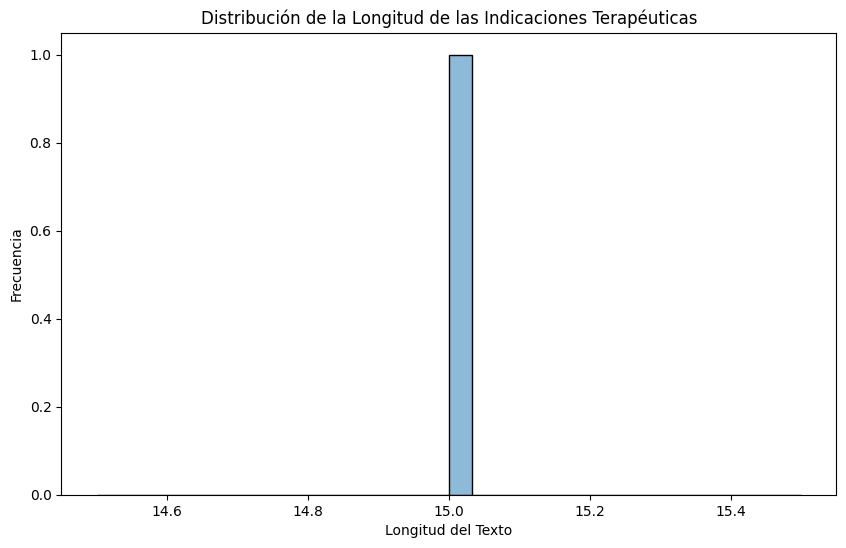

In [ ]:
# Calcular la longitud de las indicaciones terapéuticas
medicamentos_df["longitud_indicaciones"] = medicamentos_df[
    "indicaciones_terapeuticas"
].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(medicamentos_df["longitud_indicaciones"], kde=True, bins=30)
plt.title("Distribución de la Longitud de las Indicaciones Terapéuticas")
plt.xlabel("Longitud del Texto")
plt.ylabel("Frecuencia")
plt.show()

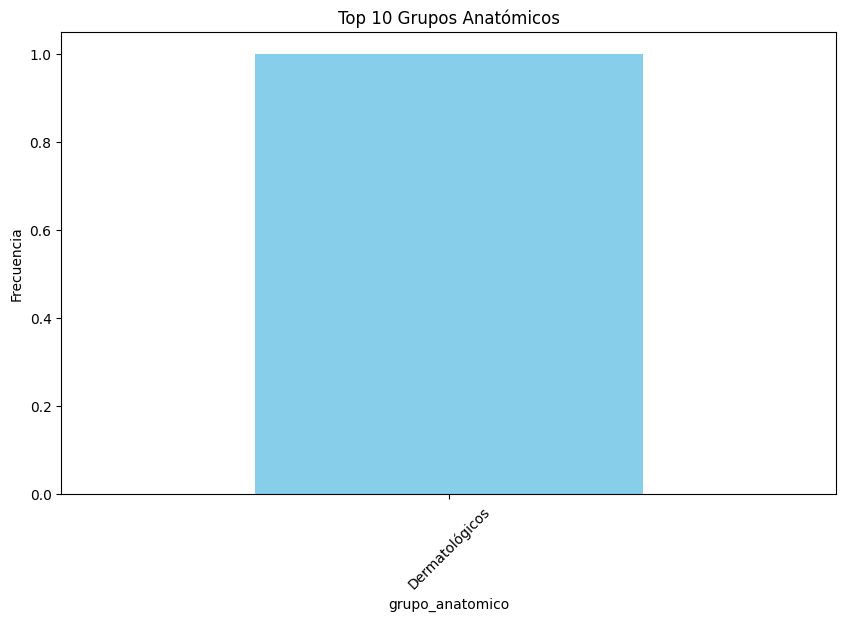

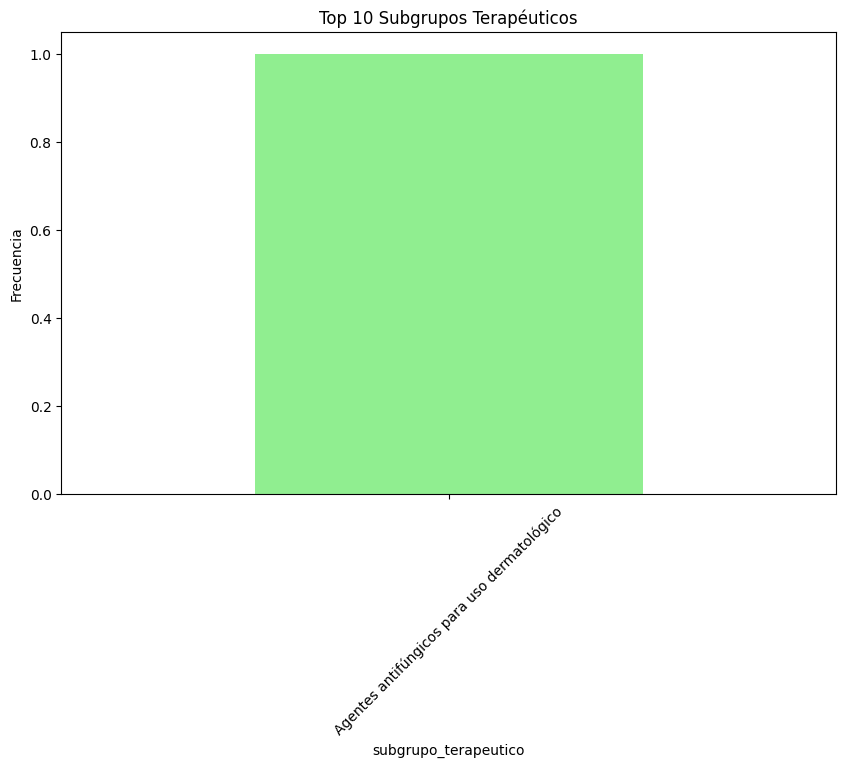

In [ ]:
# Top 10 de Grupos Anatómicos
grupo_anatomico_top = medicamentos_df["grupo_anatomico"].value_counts().head(10)

plt.figure(figsize=(10, 6))
grupo_anatomico_top.plot(kind="bar", color="skyblue")
plt.title("Top 10 Grupos Anatómicos")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.show()

# Top 10 de Subgrupos Terapéuticos
subgrupo_terapeutico_top = (
    medicamentos_df["subgrupo_terapeutico"].value_counts().head(10)
)

plt.figure(figsize=(10, 6))
subgrupo_terapeutico_top.plot(kind="bar", color="lightgreen")
plt.title("Top 10 Subgrupos Terapéuticos")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.show()

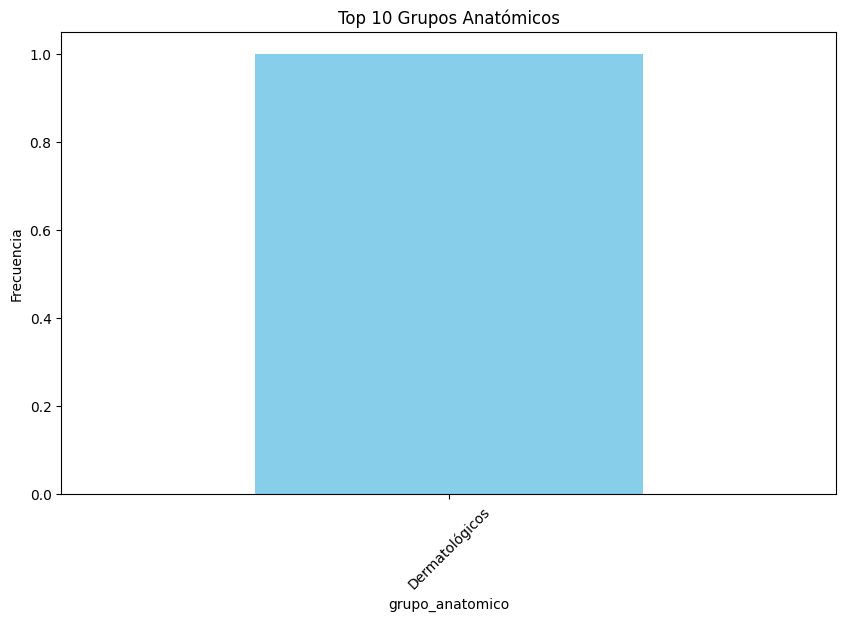

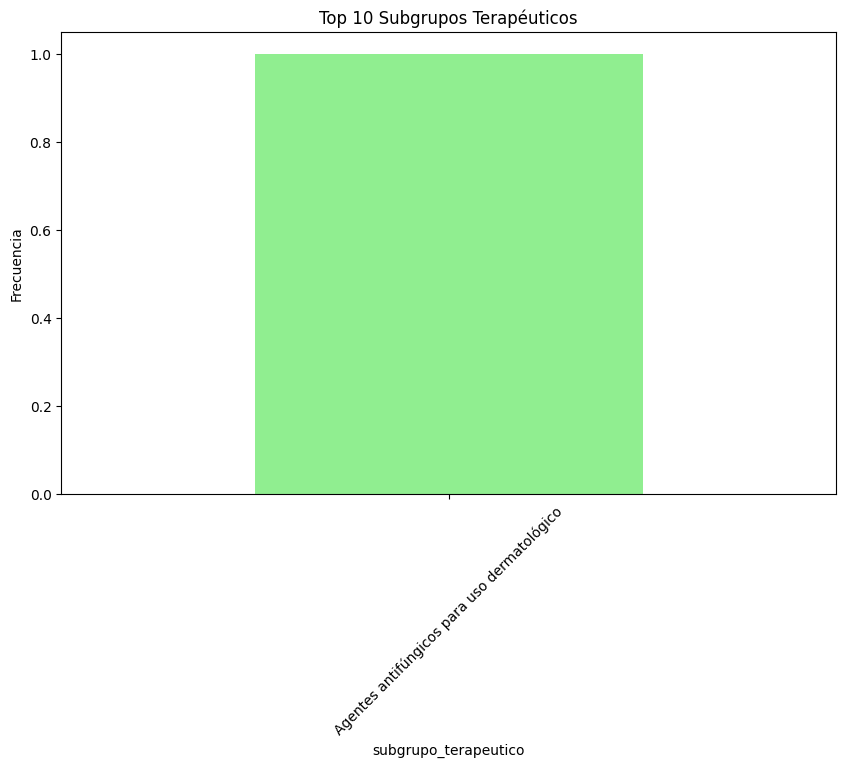

In [ ]:
# Mostrar las distribuciones de los 10 primeros grupos anatómicos y subgrupos terapéuticos
grupo_anatomico_top = medicamentos_df["grupo_anatomico"].value_counts().head(10)
subgrupo_terapeutico_top = (
    medicamentos_df["subgrupo_terapeutico"].value_counts().head(10)
)

# Visualizar las distribuciones de los Grupos Anatómicos
plt.figure(figsize=(10, 6))
grupo_anatomico_top.plot(kind="bar", color="skyblue")
plt.title("Top 10 Grupos Anatómicos")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.show()

# Visualizar las distribuciones de los Subgrupos Terapéuticos
plt.figure(figsize=(10, 6))
subgrupo_terapeutico_top.plot(kind="bar", color="lightgreen")
plt.title("Top 10 Subgrupos Terapéuticos")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.show()